==============================================================================================
## Practicum 5: Image search using textures


==============================================================================================



The exercises of this notebook will show how we can perform image similarity search using:

- Gaussian filters
- Descriptors based on texture and color

#### Problem we want to solve
- Given a query image **$x$** and a set of images **$X$** we would like to retreive the most similar to **$x$** images from  **$X$**.

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P5_Student1_Student2.zip** that includes:
    - The notebook P5_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.

**Deadline (Campus Virtual): December 8th, 23:00 h**


 The function should return a feature vector obtained by averaging each filter response on the image.  

**Hint**: Note that since at this moment we are focusing on the texture, we will not use the color of the images.

## Looking at the images

In [1]:
%matplotlib inline

import time
import scipy
import numpy as np
import skimage
from skimage import filters
from skimage import io
import os
from skimage.transform import resize

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Resize dimension 250 x 250
x = 250
y = 250

path = "./images/texturesimages/pizza/"                       
pizza_images = [resize(skimage.io.imread(path + f), (x, y)) for f in os.listdir(path)]

path = "./images/texturesimages/fish_and_chips/"
fishandchips_images = [resize(skimage.io.imread(path + f), (x, y)) for f in os.listdir(path)]

path = "./images/texturesimages/paella/"
paella_images = [resize(skimage.io.imread(path + f), (x, y)) for f in os.listdir(path)]

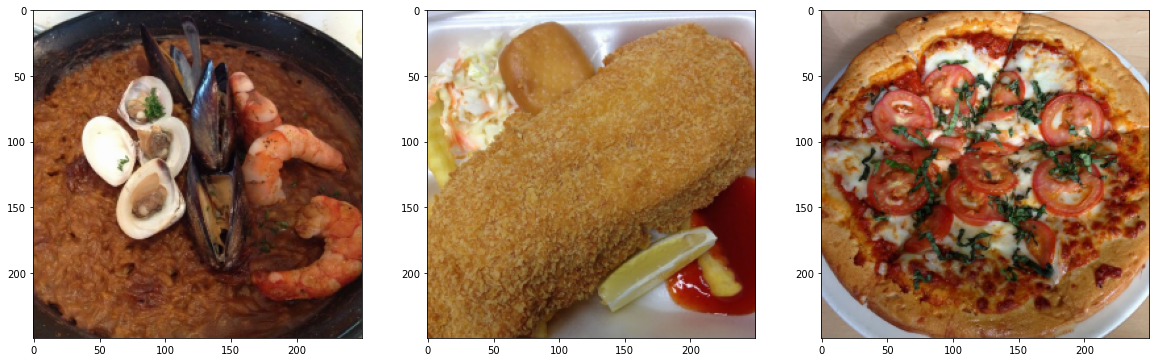

In [3]:
fig, ax= plt.subplots(ncols=3, nrows=1, figsize=(20,30))

ax[0].imshow(paella_images[0])
ax[1].imshow(fishandchips_images[0])
ax[2].imshow(pizza_images[0])
plt.show()

In [4]:
len(paella_images), len(fishandchips_images), len(pizza_images)

(30, 30, 30)

# Filter banks

We can apply a collection of multiple filters that we call a filter bank. Note that if we apply $D$ filters our feature vectors will be $D$ dimensional.

The following image shows a filter bank. In the filter bank we typically want filters to capture a combination of scales, orientations of different types of patterns. This particular filter bank is The Leung-Malik (LM) Filter Bank.

<img src="./images_notebook/filter_bank.png">


## Leung-Malik (LM) Filter Bank

In [5]:
import LM_filters

LM filters imported, the shape of the filter bank is:  (49, 49, 48)


In [6]:
filter_bank = LM_filters.makeLMfilters()
filter_bank.shape

(49, 49, 48)

### Plotting all filters

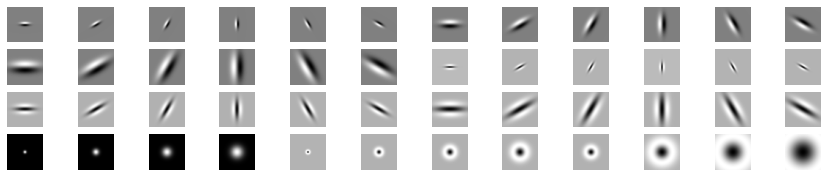

In [7]:
n_filters = filter_bank.shape[-1]

fig, ax = plt.subplots(ncols=12, nrows=4, figsize=(15,3))

k = 0
for i in range(4):
    for j in range(12):
        ax[i,j].imshow(filter_bank[:,:,k], cmap = 'gray')
        ax[i,j].axis("off")
        k = k + 1


## Exercise 5.1 Plot the convolved image by some of the filters


Make a function `visualize_features(im,  filter_bank, n_filters=5)` that recieves the `filter_bank`, an image `im` and an integer `n_filters`. 

The function  must make a plot of two rows containing in the first row, in position $k$, the image convolved by filter $k$. In the second row, in position $k$, the image of the k'th filter. The result for `n_filter=5` should look like 


<img src="./images/filters.png" >


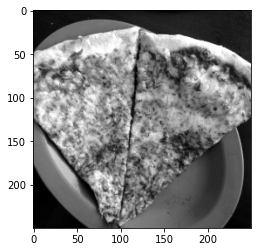

In [8]:
im = pizza_images[5]
im = skimage.color.rgb2gray(im)
plt.imshow(im, cmap="gray")

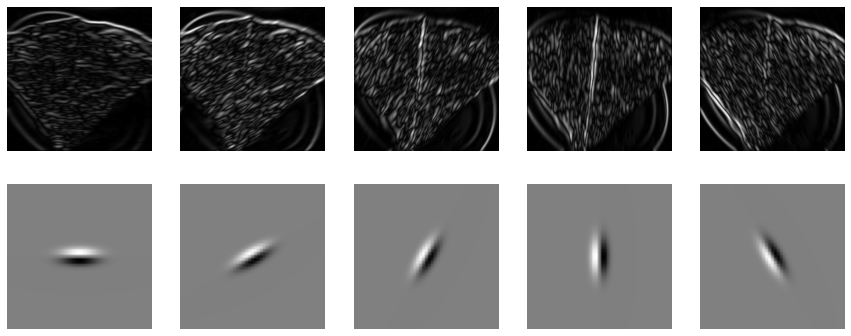

In [9]:
#First, we create a black image with same dimensions as the image we have. Then we convolve the image with
#the mask i and fill the black image with the values of the convolved image.
def visualize_features(im,  filter_bank, n_filters=5):
    fig, ax = plt.subplots(ncols=n_filters, nrows=2, figsize=(15,6))
    # complete this function
    ### Apply first 5 filters from the filter bank
    for i in range(n_filters):
        n_filter = i
        im_conv = np.zeros(im.shape)
        mask = filter_bank[:,:,n_filter]

        scipy.ndimage.convolve(im, mask, output=im_conv)
        ax[0,i].imshow(np.abs(im_conv),cmap='gray')
        ax[0,i].axis("off")

        ax[1,i].imshow( filter_bank[:,:,n_filter], cmap="gray")
        ax[1,i].axis("off")

visualize_features(im, filter_bank)


## Exercise 5.2 Constructing a feature vector for a given image


Given $D$ filters from the filter bank and a single image `image`, make a function `features_from_filter_bank(image, filter_bank, n_filters)` that returns a feature vector of shape `n_filters`. The returned vector must contain at position $k$ the mean of the absolute value of the convolved image by filter $k$.

$$
\text{feat}(x) = \left( \text{mean}( |r_1|), \dots,\text{mean}(|r_D|) \right)
$$



In [10]:
im = skimage.color.rgb2gray(pizza_images[0])

def features_from_filter_bank(image, filter_bank, n_filters):
    ## Complete this function
    im_conv = np.zeros(image.shape)
    features_for_im = np.zeros(n_filters)
    
    
    for i in range(n_filters):
        mask = filter_bank[:,:,i]
        #We convolve the image with each filter
        scipy.ndimage.convolve(image, mask, output=im_conv)
        #We take the mean of the absolute values of the convolution
        features_for_im[i] = np.mean(np.abs(im_conv))

    return features_for_im

features_for_im = features_from_filter_bank(im, filter_bank, n_filters)

## Exercise 5.3 Constructing the matrix of the feature vectors for all images

Implement a function `get_class_Features(all_images, filter_bank)` that applies `features_from_filter_bank` to get a feature vector for each of the images in the union of the three datasets (fish and chips_images, pizza, paella). It must return a matrix containing at row $k$ feature vector for the input image $k$.


Wall time: 7min 49s

In [11]:
all_images = pizza_images + fishandchips_images + paella_images

In [12]:
%%time

def get_class_features(all_images,  filter_bank):

    n_images = len(all_images)
    n_filters = filter_bank.shape[-1]
    all_feature_vectors=np.zeros((n_images,filter_bank.shape[-1]))
    # Complete

    for i in range(len(all_images)):
        im_gray = skimage.color.rgb2gray(all_images[i])
        #For each image, we process its feature vector
        all_feature_vectors[i] = features_from_filter_bank(im_gray, filter_bank, n_filters)
    return all_feature_vectors

all_feature_vectors=get_class_features(all_images,  filter_bank)

Wall time: 15min 18s


## Exercise 5.4 Visualizing the features of an image

Define a function `visualize_features` that given a feature index and an array containing all feature vectors, plots its values for the three datasets using different colors for each dataset (in total plots should contain 3 colors).


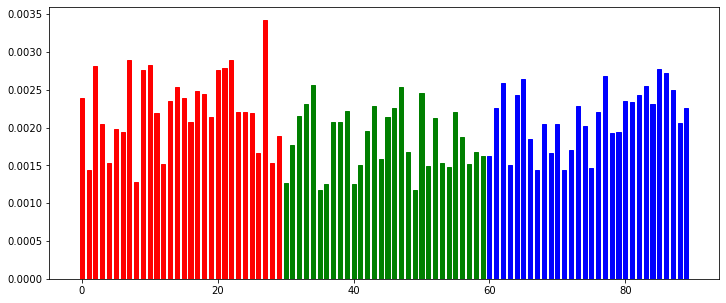

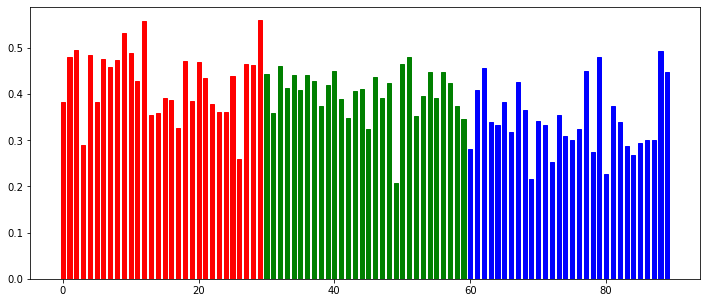

In [220]:
def visualize_features(k, all_feature_vectors):
    different_datasets= int(all_feature_vectors.shape[0] / 3) 
    fig = plt.figure(figsize=(12,5))
    image_index = []
    image_feature_values = []
    images = all_feature_vectors.shape[0]
    for image in range(images):
        feature_value = all_feature_vectors[image][k] #Extract the value of the feature k applied to image.
        
        image_index.append(image)
        image_feature_values.append(feature_value)
    
        
    barlist = plt.bar(image_index,image_feature_values, width=0.6)    
    #Plot each dataset with different color
    for image in range(images):
        if image < different_datasets:#pizza images
            barlist[image].set_color('r')
        elif image < 2*different_datasets:#fish and chips images
            barlist[image].set_color('g')
        else:#paella images
            barlist[image].set_color('b')
    
    plt.show()

    return None
#We observe that pizza images have on average more round shapes than the other dishes, because of the toppings (in feature 41)
visualize_features(25, all_feature_vectors)    
visualize_features(41, all_feature_vectors)






#### Similarity search

Let us assume $f(x) \in \mathbb{R}^D$ represents a set of features for $x$. Given a query image $x$ and another image $x^m$ from the database, we can compute the distance between images as
$$
\text{distance}\left( f(x) , \, f(x^m) \right) = \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 =  \sqrt{ \sum_{d=1}^\text{D} \left( f(x)_d - f(x^m)_d  \right)^2 }
$$

then we can find the closest image $x^{m^*}$ from the database to $x$ as $m^* =  \text{argmin}_{m} \{ \| \text{feat}(x)  - \text{feat}(x^m)  \|_2 \}$


## Exercise 5.5 Retrieving the most similar images



Implement a function `retrieve_k_images_from_X(query, X, k)` where `query` is an image,  `X` ins the array containing the features from all the images and  `k` is an integer. The function should retrieve the `k` most similar images (according to the l2 norm) and the distances from the closest images to the query image. You can include the query image since it is in `X`.

- Make a plot with the first column beeing the query image and the other k columns the closest images in the feature space.

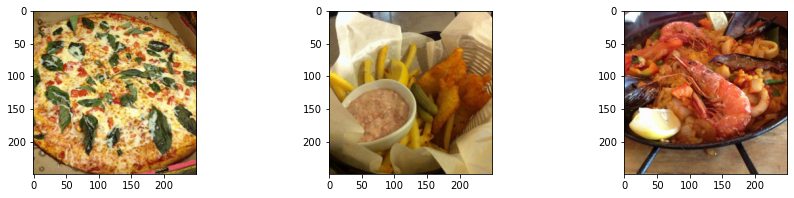

In [196]:
X = np.array(all_feature_vectors)
ind_1 = 10
ind_2 = 40
ind_3 = 70

query_1 = X[10, :]
query_2 = X[40,:]
query_3 = X[70,:]


# Display the query images
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
ax[0].imshow(all_images[10]) 
ax[1].imshow(all_images[40])
ax[2].imshow(all_images[70])
plt.show()

In [197]:

def retrieve_k_images_from_X(query, X, k):
    #Complete
    list_of_tuples = [0]*X.shape[0]
    #For each image
    for i in range(X.shape[0]):
        
        vector_i = X[i]
        #We calculate the distance from the image and the query image, as in the formula above
        list_of_tuples[i] = [i, np.linalg.norm(query - vector_i)]
    #We sort the images by distance
    list_of_tuples.sort(key=lambda x:x[1])
    #We take the first k images
    first_k_tuples=np.asarray(list_of_tuples[:k])
    return (first_k_tuples[:,0].astype(int),first_k_tuples[:,1])


In [214]:
def visualize(query_list,X, all_images, k):
   
    fig=plt.figure(figsize=(15,9))
    j=1
    for query in query_list:
        #Get the index of the k the closest_images
        closest_images,distances=retrieve_k_images_from_X(query, X, k)
        #Plot the query image
        a= fig.add_subplot(3,len(closest_images)+1,j)
        a.set_title("Query Image")
        plt.imshow(all_images[closest_images[0]])
        plt.xticks([])
        plt.yticks([])
        j+=1
        for i in range(len(closest_images)):
            #Plot the closest images, notice that the closest image is in fact the query image
            image = closest_images[i]
            b= fig.add_subplot(3,len(closest_images)+1,j)
            string= str(i+1) + "-th Best fit"
            b.set_title(string)
            plt.imshow(all_images[image])
            plt.xticks([])
            plt.yticks([])
            j+=1
    
    plt.show()

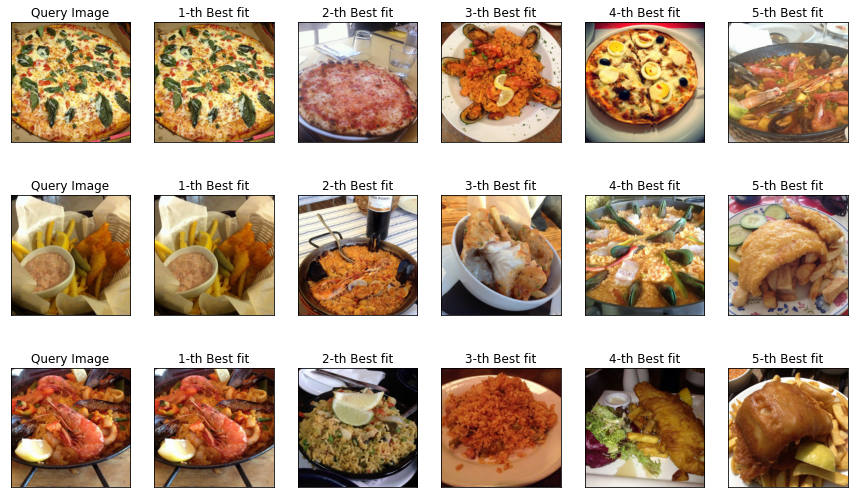

In [215]:
#Obviously, the best fit is always the query image
visualize([query_1,query_2,query_3], X, all_images,5)

## Exercise 5.6 Compute the accuracy of the algorithm: given a query image. 

Make a function 

```
accuracy(X, class_labels, k=5, query=x, class_query=y)
```

That takes as input a the dataset `X`, the `class_labels` for the images, the number of images to retrieve `k`, a query image `x` and the class of the query image `y`. Returns as output the number of retrieved images that belong to class `y` divided by the total of images retrieved `k` (this is the accuracy).

**Hint**: be careful to exclude the query image from the retrieved images.

- Compute the accuracy with k=4 with the previous images. Does the accuracy match the images retrieved from the previous exercise?


In [165]:
class_labels = np.concatenate((np.zeros(30), np.ones(30),  2*np.ones(30))).reshape(90,1)

In [172]:
def accuracy(X, class_labels, k=5, query=x, class_query=y):
    # Complete
    correct_class=0
    best_matches, distances = retrieve_k_images_from_X(query, X, k+1)#We put k+1 because we will ignore the query image, which
    #is obviously a match
    for i in (best_matches[1:]):
        if(class_labels[i]==class_query):
            correct_class+=1
            
    return correct_class/(len(best_matches)-1)



In [217]:
#The accuracy matches the images retrieved from the previous exercise, because in each of them we had
#two images that were the same class as the query, and two other images that weren't, obviously excluding the query itself

print("First Query accuracy:",accuracy(all_feature_vectors, class_labels, 4, query_1, class_labels[ind_1]))
print("Second Query accuracy:",accuracy(all_feature_vectors, class_labels, 4, query_2, class_labels[ind_2]))
print("Third Query accuracy:",accuracy(all_feature_vectors, class_labels, 4, query_3, class_labels[ind_3]))

First Query accuracy: 0.5
Second Query accuracy: 0.5
Third Query accuracy: 0.5


## Exercise 5.7 Image retrieval based on texture and color. 

Make a function ` lm_features_rgb(image, filter_bank)`  that returns the features from the filter bank concatenated per color. If the previous feature vectors had 49 components now they will have 49*3 components. 


In [179]:

def lm_features_rgb(image, filter_bank):

    n_filters = filter_bank.shape[-1]
    im_conv = np.array(image[:,:,0])
    features_for_im = np.zeros(3*n_filters)
    # Complete

    j = 0
    for i in range(n_filters):
        mask = filter_bank[:,:,i]
        
        scipy.ndimage.convolve(image[:,:,0], mask, output=im_conv)
        features_for_im[j] = np.mean(np.abs(im_conv))
        j+=1
        
        scipy.ndimage.convolve(image[:,:,1], mask, output=im_conv)
        features_for_im[j] = np.mean(np.abs(im_conv))
        j+=1
        
        scipy.ndimage.convolve(image[:,:,2], mask, output=im_conv)
        features_for_im[j] = np.mean(np.abs(im_conv))
        j+=1
        
    return features_for_im

In [180]:
%%time 
lm_rgb_features = lm_features_rgb(all_images[0], filter_bank)

Wall time: 35.3 s



## Exercise 5.8 Apply the function to all the images in the dataset

Using ` lm_features_rgb(image, filter_bank)` build the features of all the datapoints in and save them in `X_lm_rgb`.
You can parallelize the feature building process using `joblib.Parallel`. This will make the computation much faster if you have a processor with more than two threads.

In [182]:
from joblib import Parallel, delayed
import multiprocessing
#We will use multithreading to speed up the process
def get_class_features_rgb(all_images,  filter_bank):
    n_cores = multiprocessing.cpu_count() #Get the number of cores, to multithread
    n_images= len(all_images)
    #Compute the feature matrix
    all_feature_vectors_rgb = Parallel(n_jobs=n_cores)(delayed(lm_features_rgb)(all_images[i], filter_bank) for i in range(n_images))

    return np.asarray(all_feature_vectors_rgb)

X_lm_rgb = get_class_features_rgb(all_images, filter_bank) 

## 5.9 Compute the accuracy of the method using lm rgb features

Use the function implemented in 5.6 to compute the accuracy of the retrieved images using the features that contain color information. Make a plot of the 4 closest images to the query images in the `lm_rgb` space.

- Is the accuracy higher?

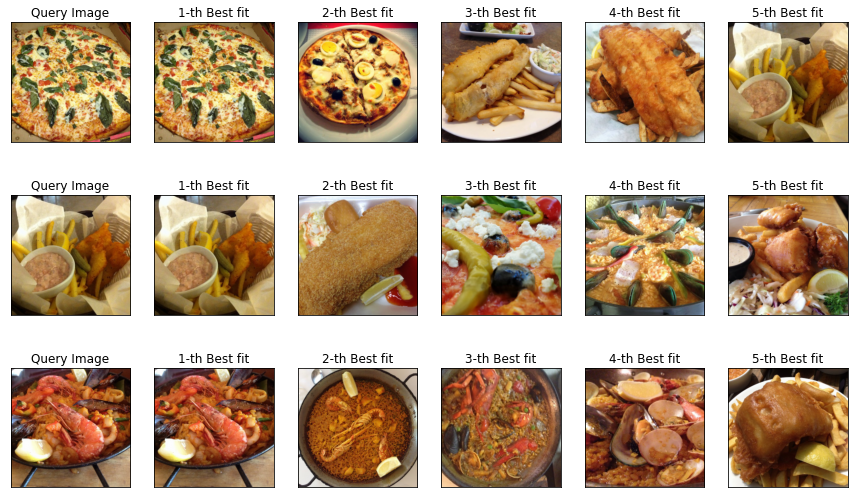

In [218]:

ind_1 = 10
ind_2 = 40
ind_3 = 70

query_1 = X_lm_rgb[ind_1,:]
query_2 = X_lm_rgb[ind_2,:]
query_3 = X_lm_rgb[ind_3,:]
#Again, we observe that the best fit is always the query image. However, all other results vary
visualize([query_1,query_2,query_3], X_lm_rgb, all_images,5)

In [219]:
#We observe that the accuracy has both increased and decreased for different queries, so we cannot conclude wether the algorithm
#is better or worse just on our result
print("Query 1 accuracy:",accuracy(X_lm_rgb, class_labels, 4, query_1, class_labels[ind_1]))
print("Query 2 accuracy:",accuracy(X_lm_rgb, class_labels, 4, query_2, class_labels[ind_2]))
print("Query 3 accuracy:",accuracy(X_lm_rgb, class_labels, 4, query_3, class_labels[ind_3]))

Query 1 accuracy: 0.25
Query 2 accuracy: 0.5
Query 3 accuracy: 0.75
